# Example 2: GLM estimation in a block design

### Natural Scenes Dataset localizer experiment, subj01, runs 01-04

---------------------

##### GLMsingle is new tool that provides efficient, scalable, and accurate single-trial fMRI response estimates.

The purpose of this Example 2 notebook is to guide the user through basic calls to GLMsingle, using a representative, small-scale test dataset (in this case, 4 runs from an fMRI localizer session containing a block design, which was part of the Natural Scenes Dataset).

The goal is to examine the effect of GLMsingle on the reliability of fMRI response estimates to the different conditions used in the localizer set (e.g. faces, bodies, objects, scenes, words). By default, the tool implements a set of optimizations that improve upon generic GLM approaches by: (1) identifying an optimal hemodynamic response function (HRF) at each voxel, (2) deriving a set of useful GLM nuisance regressors via "GLMdenoise" and picking an optimal number to include in the final GLM, and (3) applying a custom amount of ridge regularization at each voxel using an efficient technique called "fracridge". The output of GLMsingle are GLM betas reflecting the estimated percent signal change in each voxel in response to each experimental stimulus or condition being modeled.

Beyond directly improving the reliability of neural responses to repeated conditions, these optimized techniques for signal estimation can have a range of desirable downstream effects such as: improving cross-subject representational similarity within and between datasets; improving the single-image decodability of evoked neural patterns via MVPA; and, decreasing the correlation in spatial patterns observed at neighboring timepoints in analysis of fMRI GLM outputs. See our video presentation at V-VSS 2020 for a summary of these phenomena as observed in recent massive-scale fMRI datasets (the Natural Scenes Dataset and BOLD5000): https://www.youtube.com/watch?v=yb3Nn7Han8o

**Example 2 contains a full walkthrough of the process of loading an example dataset and design matrix, estimating neural responses using GLMsingle, estimating the reliability of responses at each voxel, and comparing those achieved via GLMsingle to those achieved using a baseline GLM.** After loading and visualizing formatted fMRI time-series and their corresponding design matrices, we will describe the default behavior of GLMsingle and show how to modify hyperparameters if the user desires. Throughout the notebook we will highlight important metrics and outputs using figures, print statements, and comments.

Users encountering bugs, unexpected outputs, or other issues regarding GLMsingle shouldn't hesitate to raise an issue on GitHub: https://github.com/kendrickkay/GLMsingle/issues


### Import function libraries

In [1]:
import numpy as np
import pandas as pd
import scipy
import scipy.stats as stats
import scipy.io as sio
import matplotlib.pyplot as plt
import nibabel as nib

import os
from os.path import join, exists, split
import sys
import time
import urllib.request
import copy
import warnings
from tqdm import tqdm
from pprint import pprint
warnings.filterwarnings('ignore')

import glmsingle
from glmsingle.glmsingle import GLM_single

# note: the fracridge repository is also necessary to run this code
# for example, you could do:
#      git clone https://github.com/nrdg/fracridge.git

### Set paths and download the example dataset

In [2]:
# get path to the directory to which GLMsingle was installed
homedir = split(os.getcwd())[0]

# create directory for saving data
datadir = join(homedir,'examples','data')
os.makedirs(datadir,exist_ok=True)

# create directory for saving outputs from example 1
outputdir = join(homedir,'examples','example2outputs')

print(f'directory to save example dataset:\n\t{datadir}\n')
print(f'directory to save example2 outputs:\n\t{outputdir}\n')

directory to save example dataset:
	/lab_data/tarrlab/jacobpri/GLMsingle/examples/data

directory to save example2 outputs:
	/lab_data/tarrlab/jacobpri/GLMsingle/examples/example2outputs



In [3]:
# download example dataset from GLMsingle OSF repository
# data comes from subject1, floc session from NSD dataset.
# https://www.biorxiv.org/content/10.1101/2021.02.22.432340v1.full.pdf

datafn = join(datadir,'nsdflocexampledataset.mat')

# to save time, we'll skip the download if the example dataset already exists on disk
if not exists(datafn):
    
    print(f'Downloading example dataset and saving to:\n{datafn}')
    
    dataurl = 'https://osf.io/g42tm/download'
    
    # download the .mat file to the specified directory
    urllib.request.urlretrieve(dataurl, datafn)
    
# load struct containing example dataset
X = sio.loadmat(datafn)

/lab_data/tarrlab/jacobpri/GLMsingle/examples/data/nsdflocexampledataset.mat


### Organize BOLD data, design matrices, metadata

In [13]:
# variables that will contain bold time-series and design matrices from each run
data = []
design = []

nruns = len(X['data'][0])

# iterate through each run of data
for r in range(nruns):
    
    # index into struct, append each run's timeseries data to list
    data.append(X['data'][0,r])
    
    # convert each run design matrix from sparse array to full numpy array, append
    design.append(scipy.sparse.csr_matrix.toarray(X['design'][0,r]))
    
# get shape of data volume (XYZ) for convenience
xyz = data[0].shape[:3]
xyzt = data[0].shape

# get total number of blocks - this will be the dimensionality of output betas from GLMsingle
nblocks = int(np.sum(np.concatenate(design)))

# get metadata about stimulus duration and TR
stimdur = X['stimdur'][0][0]
tr = X['tr'][0][0]

### Visualize sample data and design matrix

In [5]:
# data -> consists of several runs of 4D volume files (x,y,z,t)  where
# (t)ime is the 4th dimention.

# design -> each run has a corresponding design matrix where each column
# describes a single condition (conditions are repeated across runs). each
# design matrix is binary with 1 specfing the time (TR) when the stimulus
# is presented on the screen.

# in each run of the NSD floc experiment there were images from 10
# categories presented in blocks of duration 4 sec each. each category in
# the localizer set was presented for 6 blocks per run, and each block
# contained 8 stimuli shown for 0.5 sec each. the individual blocks are
# coded as single events in the design matrices used for the present GLM
# example. as such, there are 10 predictor columns/conditions per run, with
# the onset TRs for each of the 6 presentations indicated in the design
# matrix. notice that the condition order is pseudo-randomized. stimulus
# details are described here: https://github.com/VPNL/fLoc

# X['visual'] -> maskfile defining different regions of primary visual
# cortex, where (x,y,z) = integers 1 through 7 defines sets of voxels
# belonging to different anatomical subsets (e.g. idx 1 corresponds to V1).
# in this example, we will plot reliability values from voxels in V1.

# X['floc'] -> maskfile containing manually-defined face-selective cortical
# ROIs, where (x,y,z) = integers 1 through 3 defines sets of voxels
# belonging to distinct ROIs (e.g. idx 1 corresponds to OFA, idx 2 to
# FFA-1). in this example we will plot reliability values from voxels in
# FFA.

# get maskfiles for visual ROIs within which we will compare reliability
V1_roi = X['visual'].item()[0] == 1   # for V1
FFA_roi = X['floc'].item()[0] == 2    # for FFA-1

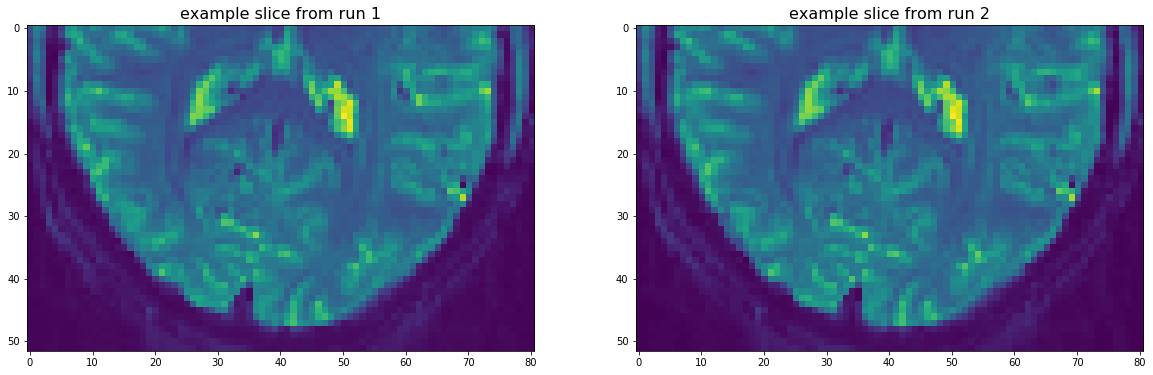

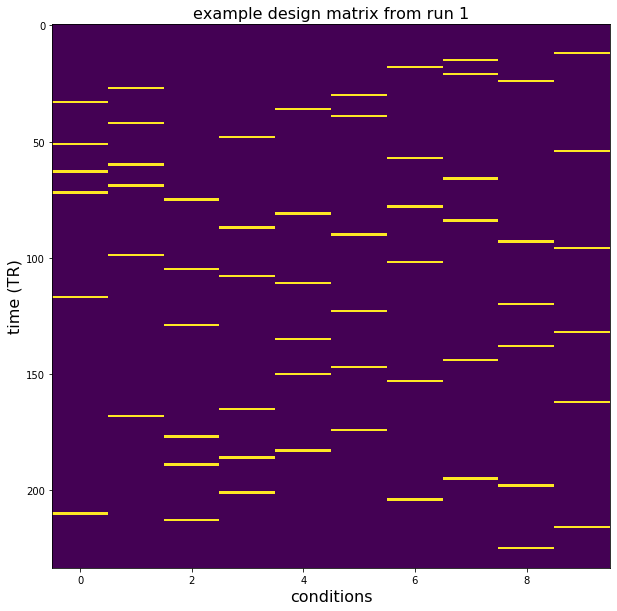

In [6]:
# plot example slices from runs 1 and 2
plt.figure(figsize=(20,6))
plt.subplot(121)
plt.imshow(data[0][:,:,20,0])
plt.title('example slice from run 1',fontsize=16)
plt.subplot(122)
plt.imshow(data[1][:,:,20,0])
plt.title('example slice from run 2',fontsize=16)

# plot example design matrix from run 1
plt.figure(figsize=(10,10))
plt.imshow(design[0],aspect='auto',interpolation='none')
plt.title('example design matrix from run 1',fontsize=16)
plt.xlabel('conditions',fontsize=16)
plt.ylabel('time (TR)',fontsize=16);

In [7]:
# print some relevant metadata
print(f'Data has {len(data)} runs\n')
print(f'There are {nblocks} total blocks in runs 1-4\n')
print(f'Shape of data from each run is: {data[0].shape}\n')
print(f'XYZ dimensionality is: {data[0].shape[:3]} (one slice only)\n')
print(f'N = {data[0].shape[3]} TRs per run\n')
print(f'Numeric precision of data is: {type(data[0][0,0,0,0])}\n')
print(f'There are {np.sum(FFA_roi)} voxels in the included FFA ROI\n')
print(f'There are {np.sum(V1_roi)} voxels in the included V1 ROI')

Data has 4 runs

There are 240 total blocks in runs 1-4

Shape of data from each run is: (52, 81, 42, 234)

XYZ dimensionality is: (52, 81, 42) (one slice only)

N = 234 TRs per run

Numeric precision of data is: <class 'numpy.float32'>

There are 484 voxels in the included FFA ROI

There are 594 voxels in the included V1 ROI


### Run GLMsingle with default parameters to estimate betas for each localizer block

In [8]:
# outputs and figures will be stored in a folder (you can specify its name
# as the 5th output to GLMsingle). model estimates can be also
# saved to the 'results' variable which is the only output of
# GLMsingle.

# optional parameters below can be assigned to a structure, i.e., opt =
# dict('wantlibrary':1, 'wantglmdenoise':1); options are the 6th input to
# GLMsingle.

# there are many options that can be specified; here, we comment on the
# main options that one might want to modify/set. defaults for the options
# are indicated below.

# wantlibrary = 1 -> fit HRF to each voxel 
# wantglmdenoise = 1 -> use GLMdenoise 
# wantfracridge = 1 -> use ridge regression to improve beta estimates 
# chunklen = 50000 -> is the number of voxels that we will
#    process at the same time. for setups with lower memory, you may need to 
#    decrease this number.

# wantmemoryoutputs is a logical vector [A B C D] indicating which of the
#     four model types to return in the output <results>. the user must be
#     careful with this, as large datasets can require a lot of RAM. if you
#     do not request the various model types, they will be cleared from
#     memory (but still potentially saved to disk). default: [0 0 0 1]
#     which means return only the final type-D model.

# wantfileoutputs is a logical vector [A B C D] indicating which of the
#     four model types to save to disk (assuming that they are computed). A
#     = 0/1 for saving the results of the ONOFF model, B = 0/1 for saving
#     the results of the FITHRF model, C = 0/1 for saving the results of the
#     FITHRF_GLMdenoise model, D = 0/1 for saving the results of the
#     FITHRF_GLMdenoise_RR model. default: [1 1 1 1] which means save all
#     computed results to disk.

# numpcstotry (optional) is a non-negative integer indicating the maximum
#     number of GLMdenoise PCs to enter into the model. default: 10.

# fracs (optional) is a vector of fractions that are greater than 0
#     and less than or equal to 1. we automatically sort in descending
#     order and ensure the fractions are unique. these fractions indicate
#     the regularization levels to evaluate using fractional ridge
#     regression (fracridge) and cross-validation. default:
#     fliplr(.05:.05:1). a special case is when <fracs> is specified as a
#     single scalar value. in this case, cross-validation is NOT performed
#     for the type-D model, and we instead blindly use the supplied
#     fractional value for the type-D model.

In [9]:
# create a directory for saving GLMsingle outputs
outputdir_glmsingle = join(homedir,'examples','example2outputs','GLMsingle')

opt = dict()

# set important fields for completeness (but these would be enabled by default)
opt['wantlibrary'] = 1
opt['wantglmdenoise'] = 1
opt['wantfracridge'] = 1

# for the purpose of this example we will keep the relevant outputs in memory
# and also save them to the disk
opt['wantfileoutputs'] = [1,1,1,1]
opt['wantmemoryoutputs'] = [1,1,1,1]

# running python GLMsingle involves creating a GLM_single object
# and then running the procedure using the .fit() routine
glmsingle_obj = GLM_single(opt)

# visualize all the hyperparameters
pprint(glmsingle_obj.params)

{'R2thresh': 0,
 'brainR2': [],
 'brainexclude': False,
 'brainthresh': [99.0, 0.1],
 'chunklen': 50000,
 'extra_regressors': False,
 'fracs': array([1.  , 0.95, 0.9 , 0.85, 0.8 , 0.75, 0.7 , 0.65, 0.6 , 0.55, 0.5 ,
       0.45, 0.4 , 0.35, 0.3 , 0.25, 0.2 , 0.15, 0.1 , 0.05]),
 'hrffitmask': 1,
 'hrfmodel': 'optimise',
 'hrfthresh': 0.5,
 'lambda': 0,
 'n_boots': 100,
 'n_jobs': 1,
 'n_pcs': 10,
 'numforhrf': 50,
 'pcR2cutoff': [],
 'pcR2cutoffmask': 1,
 'pcstop': 1.05,
 'seed': 1628732518.1078875,
 'suppressoutput': 0,
 'wantautoscale': 1,
 'wantfileoutputs': [1, 1, 1, 1],
 'wantfracridge': 1,
 'wantglmdenoise': 1,
 'wantlibrary': 1,
 'wantlss': 0,
 'wantmemoryoutputs': [1, 1, 1, 1],
 'wantparametric': 0,
 'wantpercentbold': 1}


running GLMsingle...
*** FITTING TYPE-A MODEL (ONOFF) ***

fitting model...
done.

preparing output...
done.

computing model fits...
done.

computing R^2...
done.

computing SNR...
done.


*** Saving results to /lab_data/tarrlab/jacobpri/GLMsingle/examples/example2outputs/GLMsingle/TYPEA_ONOFF.npy. ***



chunks:   0%|          | 0/4 [00:00<?, ?it/s]

*** Setting brain R2 threshold to 1.4527914222682061 ***

*** FITTING TYPE-B MODEL (FITHRF) ***



chunks: 100%|██████████| 4/4 [06:26<00:00, 96.65s/it]



*** Saving results to /lab_data/tarrlab/jacobpri/GLMsingle/examples/example2outputs/GLMsingle/TYPEB_FITHRF.npy. ***

*** DETERMINING GLMDENOISE REGRESSORS ***



chunks:   0%|          | 0/4 [00:00<?, ?it/s]

*** CROSS-VALIDATING DIFFERENT NUMBERS OF REGRESSORS ***



chunks:   0%|          | 0/4 [00:00<?, ?it/s]


*** FITTING TYPE-C MODEL (GLMDENOISE) ***



chunks: 100%|██████████| 4/4 [01:12<00:00, 18.03s/it]



*** Saving results to /lab_data/tarrlab/jacobpri/GLMsingle/examples/example2outputs/GLMsingle/TYPEC_FITHRF_GLMDENOISE.npy. ***



chunks:   0%|          | 0/4 [00:00<?, ?it/s]

*** FITTING TYPE-D MODEL (GLMDENOISE_RR) ***



chunks: 100%|██████████| 4/4 [23:59<00:00, 359.89s/it]



*** Saving results to /lab_data/tarrlab/jacobpri/GLMsingle/examples/example2outputs/GLMsingle/TYPED_FITHRF_GLMDENOISE_RR.npy. ***

*** All model types done ***

*** return model types in results ***

	elapsed time:  00:41:22


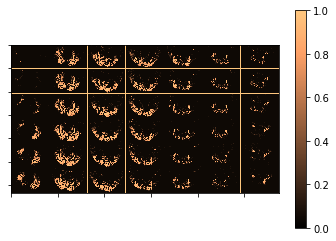

In [10]:
# this example saves output files to the folder  "example2outputs/GLMsingle"
# if these outputs don't already exist, we will perform the time-consuming call to GLMsingle;
# otherwise, we will just load from disk.

start_time = time.time()

if not exists(outputdir_glmsingle):

    print(f'running GLMsingle...')
    
    # run GLMsingle
    results_glmsingle = glmsingle_obj.fit(
       design,
       data,
       stimdur,
       tr,
       outputdir=outputdir_glmsingle)
    
    # we assign outputs of GLMsingle to the "results_glmsingle" variable.
    # note that results_glmsingle['typea'] contains GLM estimates from an ONOFF model,
    # where all images are treated as the same condition. these estimates
    # could be potentially used to find cortical areas that respond to
    # visual stimuli. we want to compare beta weights between conditions
    # therefore we are not going to include the ONOFF betas in any analyses of 
    # voxel reliability
    
else:
    print(f'loading existing GLMsingle outputs from directory:\n\t{outputdir_glmsingle}')
    
    # load existing file outputs if they exist
    results_glmsingle = dict()
    results_glmsingle['typea'] = np.load(join(outputdir_glmsingle,'TYPEA_ONOFF.npy'),allow_pickle=True).item()
    results_glmsingle['typeb'] = np.load(join(outputdir_glmsingle,'TYPEB_FITHRF.npy'),allow_pickle=True).item()
    results_glmsingle['typec'] = np.load(join(outputdir_glmsingle,'TYPEC_FITHRF_GLMDENOISE.npy'),allow_pickle=True).item()
    results_glmsingle['typed'] = np.load(join(outputdir_glmsingle,'TYPED_FITHRF_GLMDENOISE_RR.npy'),allow_pickle=True).item()

elapsed_time = time.time() - start_time

print(
    '\telapsed time: ',
    f'{time.strftime("%H:%M:%S", time.gmtime(elapsed_time))}'
)

### Summary of important outputs

In [11]:
# the outputs of GLMsingle are formally documented in its
# header. here, we highlight a few of the more important outputs:

# R2 -> is model accuracy expressed in terms of R^2 (percentage).

# betasmd -> is the full set of single-trial beta weights (X x Y x Z x
# TRIALS). beta weights are arranged in chronological order.

# HRFindex -> is the 1-index of the best fit HRF. HRFs can be recovered
# with getcanonicalHRFlibrary(stimdur,tr)

# FRACvalue -> is the fractional ridge regression regularization level
# chosen for each voxel. values closer to 1 mean less regularization.

### Plot a slice of brain showing GLMsingle outputs

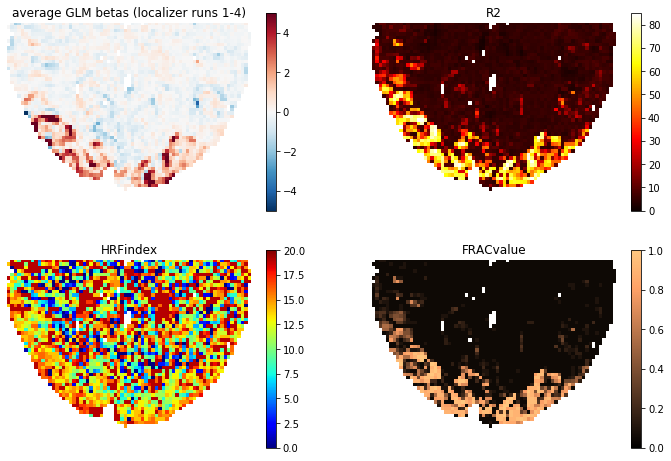

In [14]:
# we are going to plot several outputs from the FIT_HRF_GLMdenoise_RR GLM,
# which contains the full set of GLMsingle optimizations.

# we will plot betas, R2, optimal HRF indices, and the voxel frac values
plot_fields = ['betasmd','R2','HRFindex','FRACvalue']
colormaps = ['RdBu_r','hot','jet','copper']
clims = [[-5,5],[0,85],[0,20],[0,1]]

meanvol = np.squeeze(np.mean(data[0].reshape(xyzt),3))
brainmask = meanvol > 275

plt.figure(figsize=(12,8))

for i in range(len(plot_fields)):
    
    plt.subplot(2,2,i+1)
    
    if i == 0:
        # when plotting betas, for simplicity just average across all image presentations
        # this will yield a summary of whether voxels tend to increase or decrease their 
        # activity in response to the experimental stimuli (similar to outputs from 
        # an ONOFF GLM)
        plot_data = np.nanmean(np.squeeze(results_glmsingle['typed'][plot_fields[i]]),3).astype(float)
        titlestr = 'average GLM betas (localizer runs 1-4)'
    
    else:
        # plot all other voxel-wise metrics as outputted from GLMsingle
        plot_data = np.squeeze(results_glmsingle['typed'][plot_fields[i]].reshape(xyz)).astype(float)
        titlestr = plot_fields[i]
    
    plot_data[~brainmask] = np.nan # remove values outside the brain for visualization purposes
    plt.imshow(plot_data[:,5:-5,20],cmap=colormaps[i],clim=clims[i])
    plt.colorbar()
    plt.title(titlestr)
    plt.axis(False)
    

### Run a baseline GLM to compare with GLMsingle outputs

In [15]:
# for comparison purposes we are going to run a standard GLM
# without HRF fitting, GLMdenoise, or ridge regression regularization. we
# will compute the split-half reliability at each voxel using this baseline
# GLM, and then assess whether reliability improves using the output betas
# from GLMsingle. 

# output directory for baseline GLM
outputdir_baseline = join(outputdir,'GLMbaseline')

# we will run this baseline GLM by changing the default settings in GLMsingle 
# contained within the "opt" structure.
opt = dict() 

# turn off optimizations 
opt['wantlibrary'] = 0 # switch off HRF fitting
opt['wantglmdenoise'] = 0 # switch off GLMdenoise
opt['wantfracridge'] = 0 # switch off ridge regression


# for the purpose of this example we will keep the relevant outputs in memory
# and also save them to the disk...
# the first two indices are the ON-OFF GLM and the baseline single-trial GLM. 
# no need to save the third (+ GLMdenoise) and fourth (+ fracridge) outputs
# since they will not even be computed
opt['wantmemoryoutputs'] = [1,1,0,0] 
opt['wantfileoutputs'] = [1,1,0,0]

# running python GLMsingle involves creating a GLM_single object
# and then running the procedure using the .fit() routine
glmbaseline_obj = GLM_single(opt)

# visualize the hyperparameters, including the modified baseline opts
pprint(glmbaseline_obj.params)

{'R2thresh': 0,
 'brainR2': [],
 'brainexclude': False,
 'brainthresh': [99.0, 0.1],
 'chunklen': 50000,
 'extra_regressors': False,
 'fracs': array([1.  , 0.95, 0.9 , 0.85, 0.8 , 0.75, 0.7 , 0.65, 0.6 , 0.55, 0.5 ,
       0.45, 0.4 , 0.35, 0.3 , 0.25, 0.2 , 0.15, 0.1 , 0.05]),
 'hrffitmask': 1,
 'hrfmodel': 'optimise',
 'hrfthresh': 0.5,
 'lambda': 0,
 'n_boots': 100,
 'n_jobs': 1,
 'n_pcs': 10,
 'numforhrf': 50,
 'pcR2cutoff': [],
 'pcR2cutoffmask': 1,
 'pcstop': 1.05,
 'seed': 1628732518.1078875,
 'suppressoutput': 0,
 'wantautoscale': 1,
 'wantfileoutputs': [1, 1, 0, 0],
 'wantfracridge': 0,
 'wantglmdenoise': 0,
 'wantlibrary': 0,
 'wantlss': 0,
 'wantmemoryoutputs': [1, 1, 0, 0],
 'wantparametric': 0,
 'wantpercentbold': 1}


In [16]:
start_time = time.time()

# if these outputs don't already exist, we will perform the call to
# GLMsingle; otherwise, we will just load from disk.
if not exists(outputdir_baseline):
    
    print(f'running GLMsingle...')

    # run GLMsingle, fitting the baseline GLM
    results_assumehrf = glmbaseline_obj.fit(
       design,
       data,
       stimdur,
       tr,
       outputdir=outputdir_baseline)
    
else:
    
    print(f'loading existing GLMsingle outputs from directory:\n\t{outputdir_glmsingle}')
    
    results_assumehrf = dict()
    results_assumehrf['typea'] = np.load(join(outputdir_baseline,'TYPEA_ONOFF.npy'),allow_pickle=True).item()
    results_assumehrf['typeb'] = np.load(join(outputdir_baseline,'TYPEB_FITHRF.npy'),allow_pickle=True).item()
    
    # note that even though we are loading TYPEB_FITHRF betas, HRF fitting
    # has been turned off and this struct field will thus contain the
    # outputs of a GLM fit using the canonical HRF.
    
# get shape of output betas for later reference
xyzn = (xyz[0],xyz[1],xyz[2],nblocks)
    
elapsed_time = time.time() - start_time
print(
    '\telapsed time: ',
    f'{time.strftime("%H:%M:%S", time.gmtime(elapsed_time))}'
)

running GLMsingle...
*** FITTING TYPE-A MODEL (ONOFF) ***

fitting model...
done.

preparing output...
done.

computing model fits...
done.

computing R^2...
done.

computing SNR...
done.


*** Saving results to /lab_data/tarrlab/jacobpri/GLMsingle/examples/example2outputs/GLMbaseline/TYPEA_ONOFF.npy. ***



chunks:   0%|          | 0/4 [00:00<?, ?it/s]

*** Setting brain R2 threshold to 1.4527914222682061 ***

*** FITTING TYPE-B MODEL (FITHRF) ***



chunks: 100%|██████████| 4/4 [00:12<00:00,  3.20s/it]



*** Saving results to /lab_data/tarrlab/jacobpri/GLMsingle/examples/example2outputs/GLMbaseline/TYPEB_FITHRF.npy. ***

*** All model types done ***

*** return model types in results ***

	elapsed time:  00:00:28


In [17]:
# create dictionary containing the GLM betas from the four different models we will compare.
# note that the "assume hrf" betas come from the "typeb" field of our baseline GLM
# (with HRF fitting turned off), and that the "fit hrf" betas also come from 
# the "typeb" field of the GLM that ran with all default GLMsingle routines
# enabled

models = dict()
models['assumehrf'] = results_assumehrf['typeb']['betasmd'].reshape(xyzn)
models['fithrf'] = results_glmsingle['typeb']['betasmd']
models['fithrf_glmdenoise'] = results_glmsingle['typec']['betasmd']
models['fithrf_glmdenoise_rr'] = results_glmsingle['typed']['betasmd']

### Organize condition indices to prepare for reliability calculations

In [18]:
# to compare the results of different GLMs we are going to calculate the
# voxel-wise split-half reliablity for each model. reliability values
# reflect a correlation between beta weights for repeated presentations of
# the same conditions. in short, we are going to check how
# reliable/reproducible are the single trial responses to repeated
# conditions estimated with each GLM type.

# this NSD scan session has a large number of images that are just shown
# once during the session, some images that are shown twice, and a few that
# are shown three times. in the code below, we are attempting to locate the
# indices in the beta weight GLMsingle outputs modelmd(x,y,z,trials) that
# correspond to repeated images. here we only consider stimuli that have
# been presented at least twice. for the purpose of the example we ignore
# the 3rd repetition of the stimulus.

# consolidate design matrices
designALL = np.concatenate(design,axis=0)

# construct a vector containing 0-indexed condition numbers in chronological order
corder = []
for p in range(designALL.shape[0]):
    if np.any(designALL[p]):
        corder.append(np.argwhere(designALL[p])[0,0])
        
corder = np.array(corder)

In [19]:
# let's take a look at the first few entries
print(corder[:3])

# note that [9 7 6] means that the first stimulus block involved
# presentation of the 9th condition (zero-indexed), the second stimulus block 
# involved presentation of the 7th condition, and so on.

[9 7 6]


In [20]:
# in order to compute split-half reliability, we have to do some indexing.
# we want to find all repetitions of the same condition. for example we can
# look up when during the 4 blocks image 1 was repeated. each condition should
# be repeated exactly 24 times.

repindices = []

for p in range(designALL.shape[1]): # loop over every condition
    temp = np.argwhere(corder==p)[:,0] # find indices where this condition was shown
    if len(temp) >= 2:
        repindices.append(temp)

repindices = np.vstack(np.array(repindices)).T      

print(f'There are {repindices.shape[1]} repeated conditions in the experiment\n')
print(f'There are {repindices.shape[0]} instances of each repeated condition across 4 runs\n')
print(f'Betas from blocks containing the first localizer condition can be found at the following indices of GLMsingle output beta matrices:\n\n{repindices[:,0]}')


There are 10 repeated conditions in the experiment

There are 24 instances of each repeated condition across 4 runs

Betas from blocks containing the first localizer condition can be found at the following indices of GLMsingle output beta matrices:

[  7  12  16  19  33  56  63  75  84  96 105 113 125 136 141 150 170 173
 194 201 203 213 226 236]


In [21]:
# now, for each voxel we are going to correlate beta weights describing the
# response to averaged even presentations of the 10 conditions with beta
# weights describing the responses from the averaged odd repetitions of the
# same conditions, over time. with 10 conditions in the localizer set, the
# split-half correlation for each voxel will thus reflect the relationship
# between two vectors with 10 beta weights each.


### Visualize FFA and V1 ROIs, within which we will compute reliability

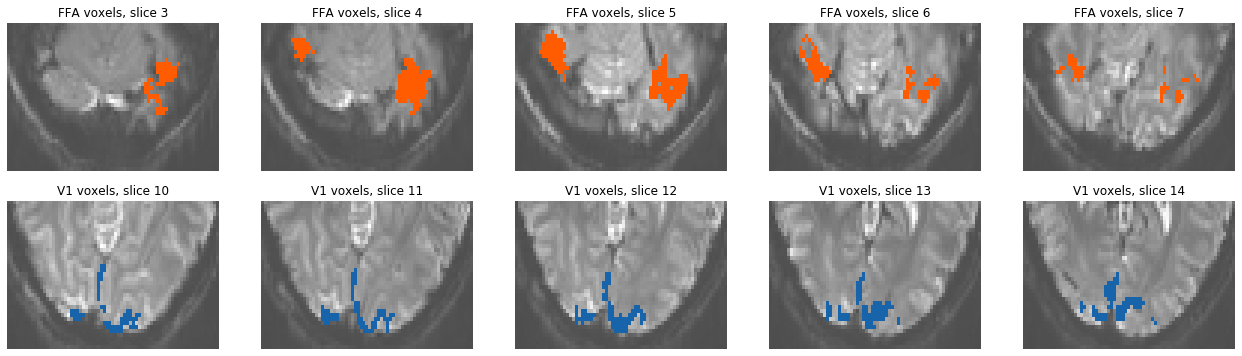

In [22]:
plt.figure(figsize=(22,6))
c=1

FFA_roi_ = np.full(FFA_roi.shape, np.nan)
FFA_roi_[FFA_roi] = 1

V1_roi_ = np.full(V1_roi.shape, np.nan)
V1_roi_[V1_roi] = 1

# show some slices containing FFA voxels overlaid against the mean volume from run 1
for s in range(3,8):
    plt.subplot(2,5,c)
    plt.imshow(meanvol[15:,5:-5,s]/np.nanmax(meanvol[15:,5:-5,s]),aspect='auto',cmap='gray',clim=(0,1), alpha=0.7)
    plt.imshow(FFA_roi_[15:,5:-5,s],aspect='auto',cmap='hot',clim=(0,2))
    plt.title('FFA voxels, slice ' + str(s))
    plt.box(False)
    plt.axis(False)
    c+=1

# show some slices containing V1 voxels overlaid against the mean volume from run 1
for s in range(10,15):
    plt.subplot(2,5,c)
    plt.imshow(meanvol[15:,5:-5,s]/np.nanmax(meanvol[15:,5:-5,s]),aspect='auto',cmap='gray',clim=(0,1), alpha=0.7)
    plt.imshow(V1_roi_[15:,5:-5,s],aspect='auto',cmap='Blues',clim=(0,1.25))
    plt.title('V1 voxels, slice ' + str(s))
    plt.box(False)
    plt.axis(False)
    c+=1
    

### Compute median split-half reliability within the ROIs for each GLM version

In [23]:
# To calculate the split-half reliability we are going to average the odd
# and even beta weights extracted from the same condition and calculate the
# correlation coefficent between these values. We do this for each voxel
# inside the primary visual cortex and face-selective cortical ROIs.

vox_reliabilities = [] # output variable for reliability values

modelnames = list(models.keys())
n_cond = repindices.shape[1]

# for each beta version...
for m in range(len(modelnames)):
    
    print(f'computing reliability for beta version: {modelnames[m]}')
    time.sleep(1)
    
    # organize the betas by (X,Y,Z,repeats,conditions) using the repindices variable
    betas = models[modelnames[m]][:,:,:,repindices]
    x,y,z = betas.shape[:3] 
    
    # create output volume for voxel reliability scores
    rels = np.full((x,y,z),np.nan)
    
    # loop through voxels in the 3D volume...
    for xx in tqdm(range(x)):
        for yy in range(y):
            for zz in range(z):
                
                # process only if within ROIs of interest
                if FFA_roi[xx,yy,zz] or V1_roi[xx,yy,zz]: 
                    
                    # for this voxel, get beta matrix of (repeats,conditions)
                    vox_data = betas[xx,yy,zz]
                    
                    # average odd and even betas after shuffling
                    even_data = np.nanmean(vox_data[::2],axis=0)
                    odd_data = np.nanmean(vox_data[1::2],axis=0)

                    # reliability at a given voxel is pearson correlation between the 
                    # odd- and even-presentation beta vectors
                    rels[xx,yy,zz] = np.corrcoef(even_data,odd_data)[1,0]
          
    vox_reliabilities.append(rels)

computing reliability for beta version: assumehrf


100%|██████████| 52/52 [00:00<00:00, 125.34it/s]


computing reliability for beta version: fithrf


100%|██████████| 52/52 [00:00<00:00, 125.37it/s]


computing reliability for beta version: fithrf_glmdenoise


100%|██████████| 52/52 [00:00<00:00, 119.29it/s]


computing reliability for beta version: fithrf_glmdenoise_rr


100%|██████████| 52/52 [00:00<00:00, 121.47it/s]


### Assess change in reliability yielded by GLMsingle

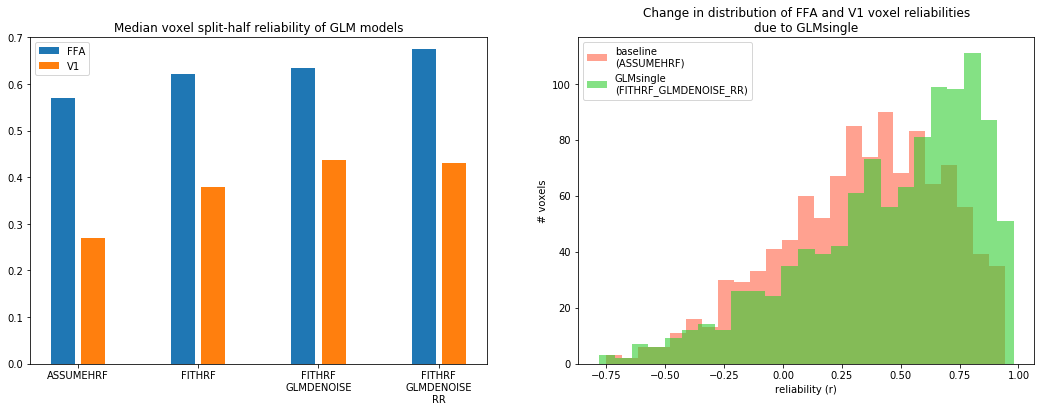

In [24]:
# to perform a comparison between all GLM versions available in our visual
# ROIs, we will simply loop through the beta versions, isolate the voxels
# of interest, compute the median split-half correlation value within each
# ROI, and plot using a bar graph.

comparison = []
for vr in vox_reliabilities:
    comparison.append([np.nanmedian(vr[FFA_roi]), 
                       np.nanmedian(vr[V1_roi])])
comparison = np.vstack(comparison)

plt.figure(figsize=(18,6))
plt.subplot(121)
plt.bar(np.arange(len(comparison[:,0]))-0.125,comparison[:,0],width=0.2)
plt.bar(np.arange(len(comparison[:,1]))+0.125,comparison[:,1],width=0.2)
plt.ylim([0,0.7])

plt.legend(['FFA','V1'])
plt.title('Median voxel split-half reliability of GLM models')
plt.xticks(np.arange(4),np.array(['ASSUMEHRF', 'FITHRF', 'FITHRF\nGLMDENOISE', 'FITHRF\nGLMDENOISE\nRR']));

# we can also look at how distributions of FFA/V1 voxel reliabilities change 
# between the baseline GLM and the final output of GLMsingle (fithrf+GLMdenoise+RR)
plt.subplot(122)
plt.hist(vox_reliabilities[0].reshape(-1),25,alpha=0.6,color='tomato');
plt.hist(vox_reliabilities[3].reshape(-1),25,alpha=0.6,color='limegreen');
plt.xlabel('reliability (r)')
plt.ylabel('# voxels')
plt.legend(['baseline\n(ASSUMEHRF)', 'GLMsingle\n(FITHRF_GLMDENOISE_RR)'])
plt.title('Change in distribution of FFA and V1 voxel reliabilities\ndue to GLMsingle');


In [25]:
# notice that there is systematic increase in reliability moving from the
# first to the second to the third to the final fourth version of the GLM
# results, within both the early visual and face-selective ROIs. these
# increases reflect, respectively, the addition of HRF fitting, the
# derivation and use of data-driven nuisance regressors, and the use of
# ridge regression as a way to regularize the instability of closely spaced
# experimental trials. depending on one's experimental goals, it is
# possible with setting of option flags to activate a subset of these
# analysis features.

# also, keep in mind that in the above figure, we are simply showing the
# median as a metric of the central tendency (you may want to peruse
# individual voxels in scatter plots, for example).

# note also that median reliability is consistently higher in the FFA ROI
# than in the V1 ROI in this analysis of localizer data. importantly, this
# does not imply that V1 data are inherently noisy or unreliable across the
# NSD dataset (e.g. in the NSD core experiment). here we are analyzing GLM
# outputs from the localizer dataset, which was designed to identify neural
# ROIs whose voxel tuning profiles vary meaningfully across a small,
# curated set of high-level stimulus categories. as such, we would expect
# the FFA voxels to have relatively more well-defined tuning curves, with
# more substantial variability in GLM betas between the localizer
# categories, than the V1 voxels, whose tuning is determined by lower-level
# image features that do not necessarily vary in systematic ways between
# the localizer categories. for these reasons, one might expect that
# split-half correlations would be somewhat lower in the V1 voxels using
# our particular metric of reliability (odd-even correlation) in this
# dataset. different metrics of reliability may generate different patterns
# of results when comparing these two ROIs, and we would also expect
# results to vary depending on the stimulus set.


### Plot voxel-wise change in reliability due to GLMsingle as an overlay on the brain

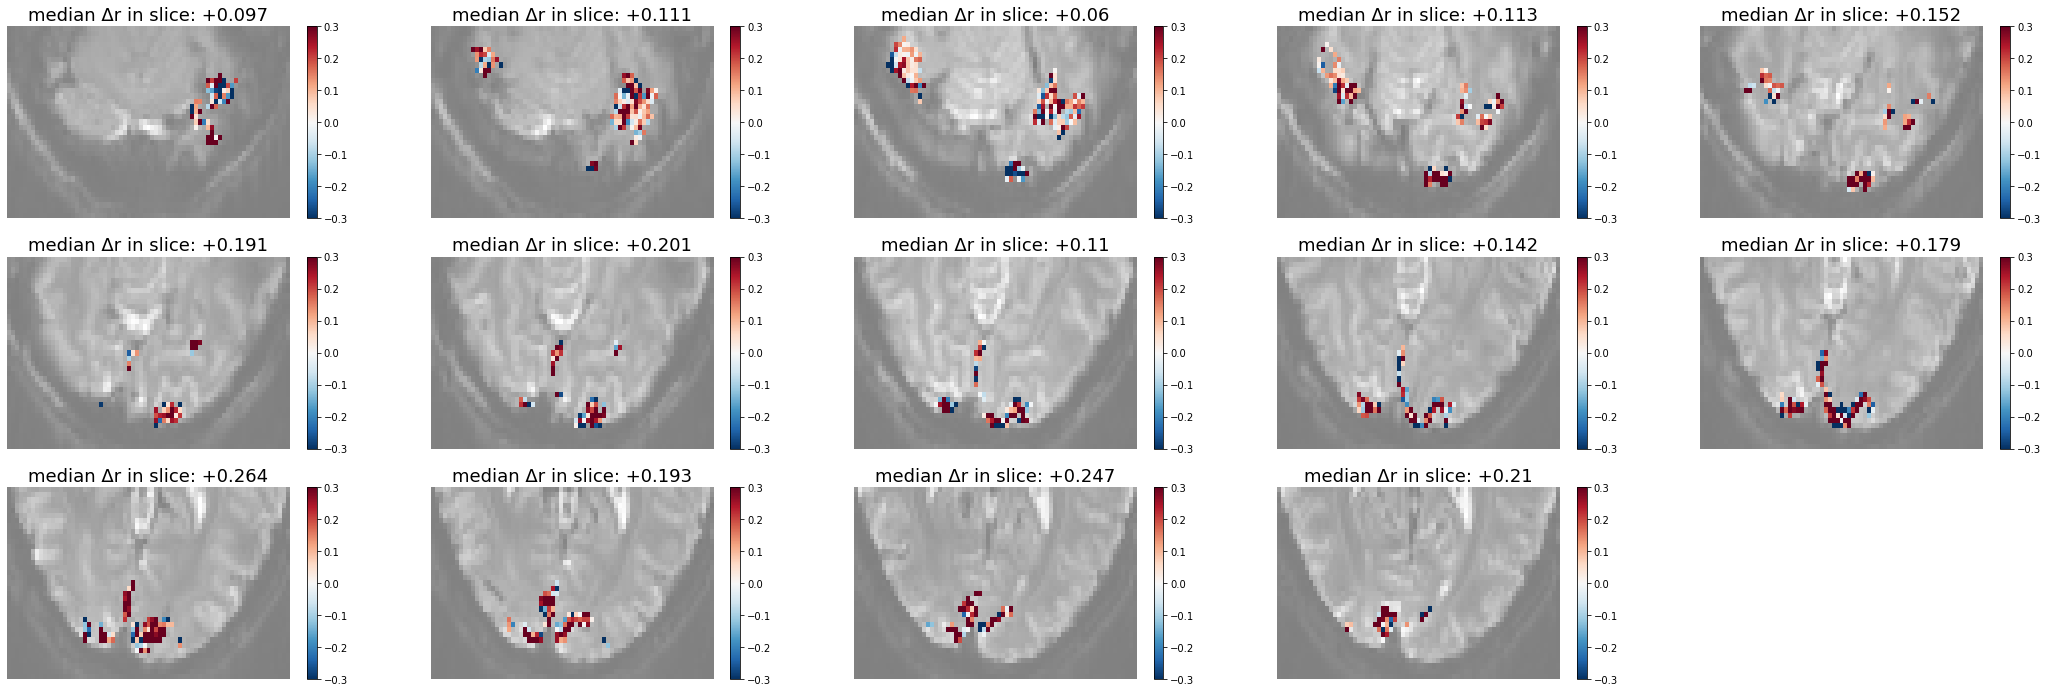

In [26]:
# for a final visualization, we can look at the relationship between voxels'
# locations in anatomical space and the degree to which GLMsingle confers
# benefit over a baseline GLM

# comparison is the final output (FIT_HRF_GLMDENOISE_RR) vs. the baseline
# GLM (ASSUME_HRF)
vox_improvement = vox_reliabilities[3] - vox_reliabilities[0]

plt.figure(figsize=(55/1.5,18/1.5))
c=1
for s in range(3,17):
    plot_data = vox_improvement[15:,5:-5,s]
    plt.subplot(3,5,c)
    plt.imshow(meanvol[15:,5:-5,s]/np.nanmax(meanvol[15:,5:-5,s]),
               aspect='auto',cmap='gray',clim=(0,1), alpha=0.5)
    plt.imshow(plot_data,aspect='auto',cmap='RdBu_r',clim=(-0.3,0.3))
    plt.title(f'median \u0394r in slice: +{np.round(np.nanmedian(plot_data),3)}',fontsize=18)
    plt.colorbar()
    plt.box(False)
    plt.axis(False)
    c+=1
    
# in these plots, higher positive values (shades of red) reflect a greater benefit from 
# applying GLMsingle. 